In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [4]:
df_train.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [5]:
df_train.describe(include=["O"]).T

,count,unique,top,freq
Sex,750000,2,female,375721


In [6]:
df_train.nunique()

id            750000
Sex                2
Age               60
Height            86
Weight            91
Duration          30
Heart_Rate        63
Body_Temp         75
Calories         277
dtype: int64

In [7]:
df_train.isnull().sum().sort_values(ascending=False)

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

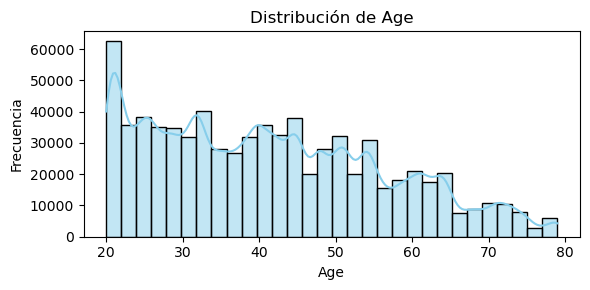

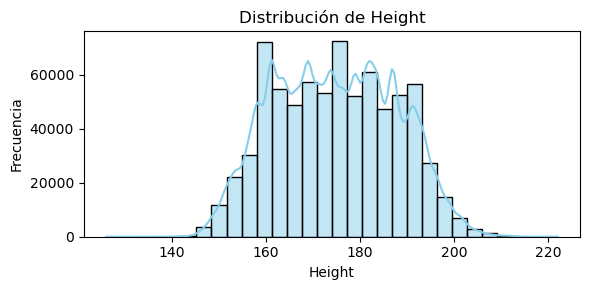

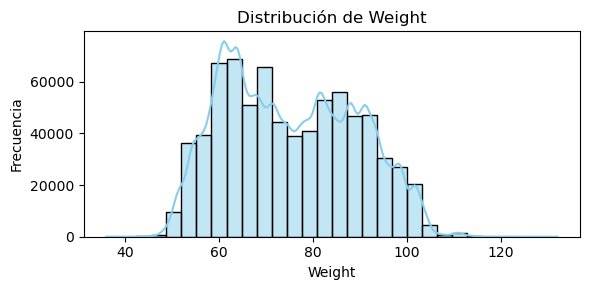

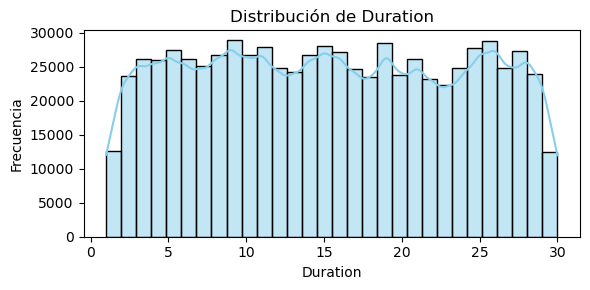

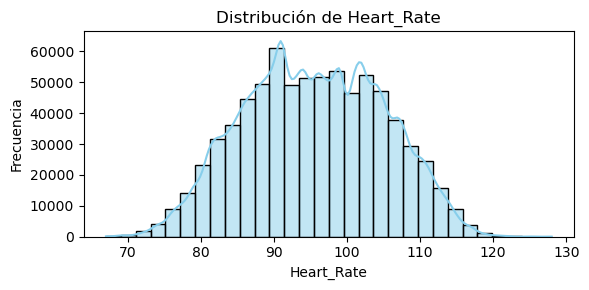

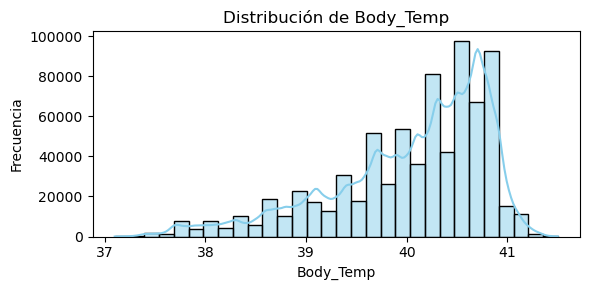

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df_train[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()


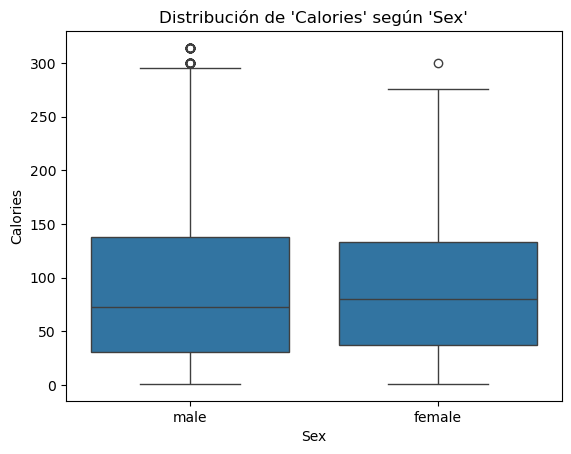

In [9]:
sns.boxplot(x='Sex', y='Calories', data=df_train)
plt.title("Distribución de 'Calories' según 'Sex'")
plt.show()

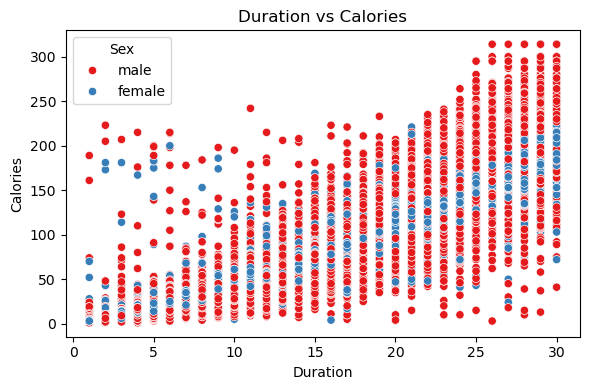

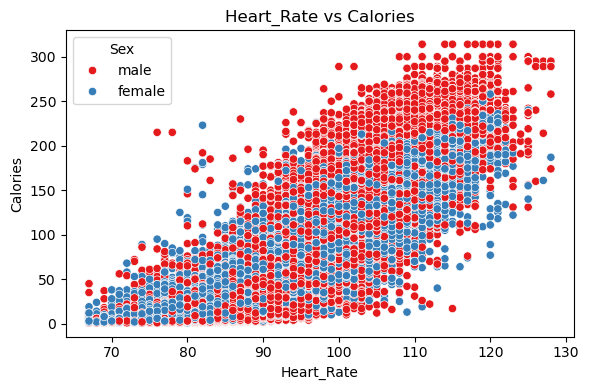

C:\Users\S94\AppData\Local\Temp\ipykernel_12632\2945042241.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\S94\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


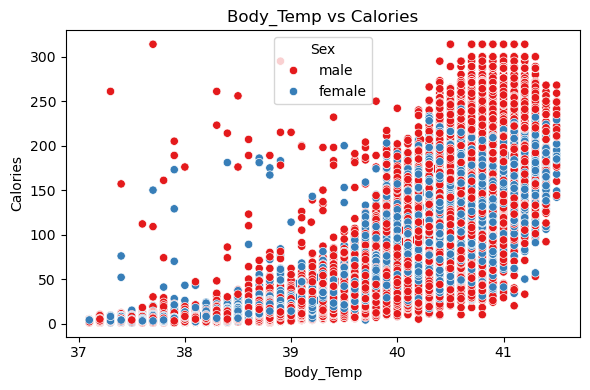

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables con alta correlación observada
predictoras_clave = ['Duration', 'Heart_Rate', 'Body_Temp']

for col in predictoras_clave:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_train[col], y=df_train['Calories'], hue=df_train['Sex'], palette='Set1')
    plt.title(f'{col} vs Calories')
    plt.xlabel(col)
    plt.ylabel('Calories')
    plt.tight_layout()
    plt.show()


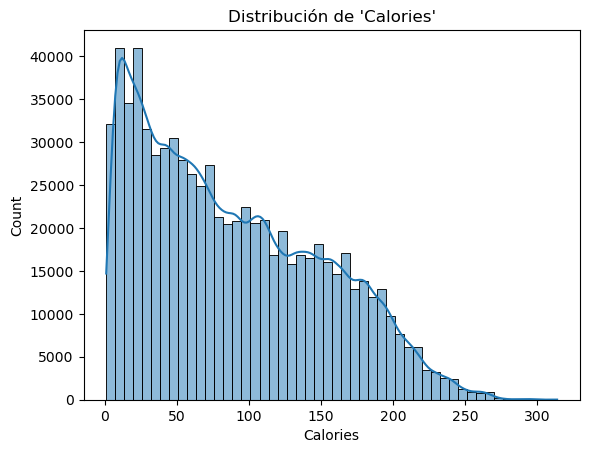

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_train['Calories'], bins=50, kde=True)
plt.title("Distribución de 'Calories'")
plt.show()

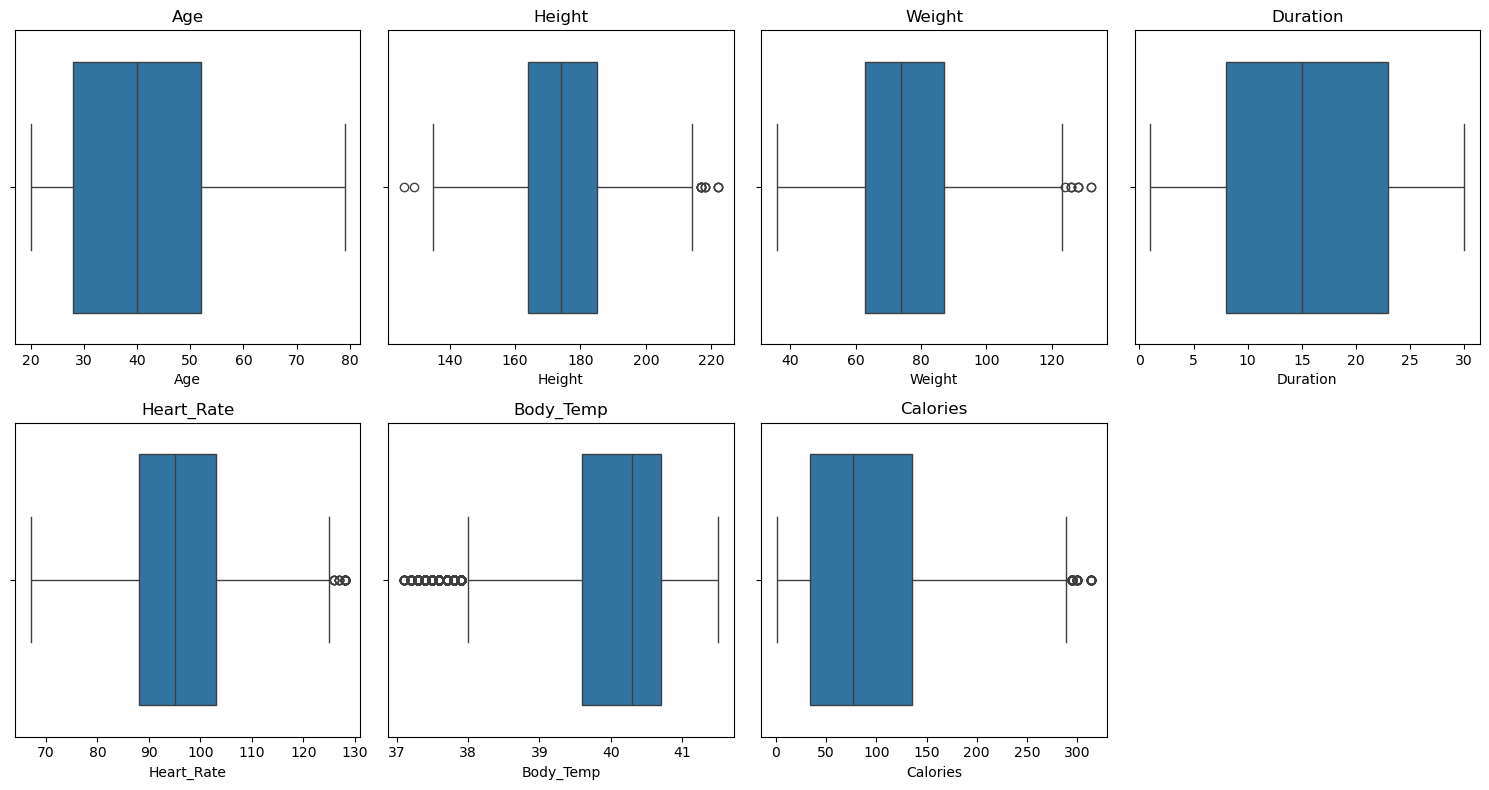

In [12]:
#REVISANDO OUTLIERS
numerical_cols = df_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ["id"]]  # target queda fuera

import matplotlib.pyplot as plt
import seaborn as sns

# Ajustar tamaño general
plt.figure(figsize=(15, 8))

# Un boxplot por cada columna numérica
for i, col in enumerate(numerical_cols):
    plt.subplot(2, (len(numerical_cols) + 1) // 2, i + 1)
    sns.boxplot(x=df_train[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

In [13]:
#COMENZANDO A APLICAR WINSORIZE PARA MANEJAR OUTLIERS
def winsorize_iqr(df_train, df_test, columns, force_non_negative=True):
    limits = {}  # Guardar límites por columna

    for col in columns:
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Forzar límite inferior a 0 si se desea
        if force_non_negative:
            lower = max(0, lower)

        limits[col] = (lower, upper)

        # Aplicar winsorizing a df_train
        df_train[col] = np.where(df_train[col] < lower, lower,
                          np.where(df_train[col] > upper, upper, df_train[col]))

        # Aplicar winsorizing a df_test usando los mismos límites
        df_test[col] = np.where(df_test[col] < lower, lower,
                         np.where(df_test[col] > upper, upper, df_test[col]))
        
    return limits


In [14]:
cols_to_winsorize = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

# Aplicar winsorizing
iqr_limits = winsorize_iqr(df_train, df_test, cols_to_winsorize)


In [15]:
# Crear columna IMC (Índice de Masa Corporal)
df_train['IMC'] = df_train['Weight'] / ((df_train['Height'] / 100) ** 2)
df_test['IMC'] = df_test['Weight'] / ((df_test['Height'] / 100) ** 2)

In [16]:
def winsorize_column_iqr(df_train, df_test, column, force_non_negative=True):
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if force_non_negative:
        lower = max(0, lower)

    # Aplicar winsorizing a df_train
    df_train[column] = np.where(df_train[column] < lower, lower,
                         np.where(df_train[column] > upper, upper, df_train[column]))

    # Aplicar winsorizing a df_test
    df_test[column] = np.where(df_test[column] < lower, lower,
                        np.where(df_test[column] > upper, upper, df_test[column]))

    return lower, upper

# Aplicar solo a IMC
winsorize_column_iqr(df_train, df_test, 'IMC')


(19.90600066866376, 28.836715254129654)

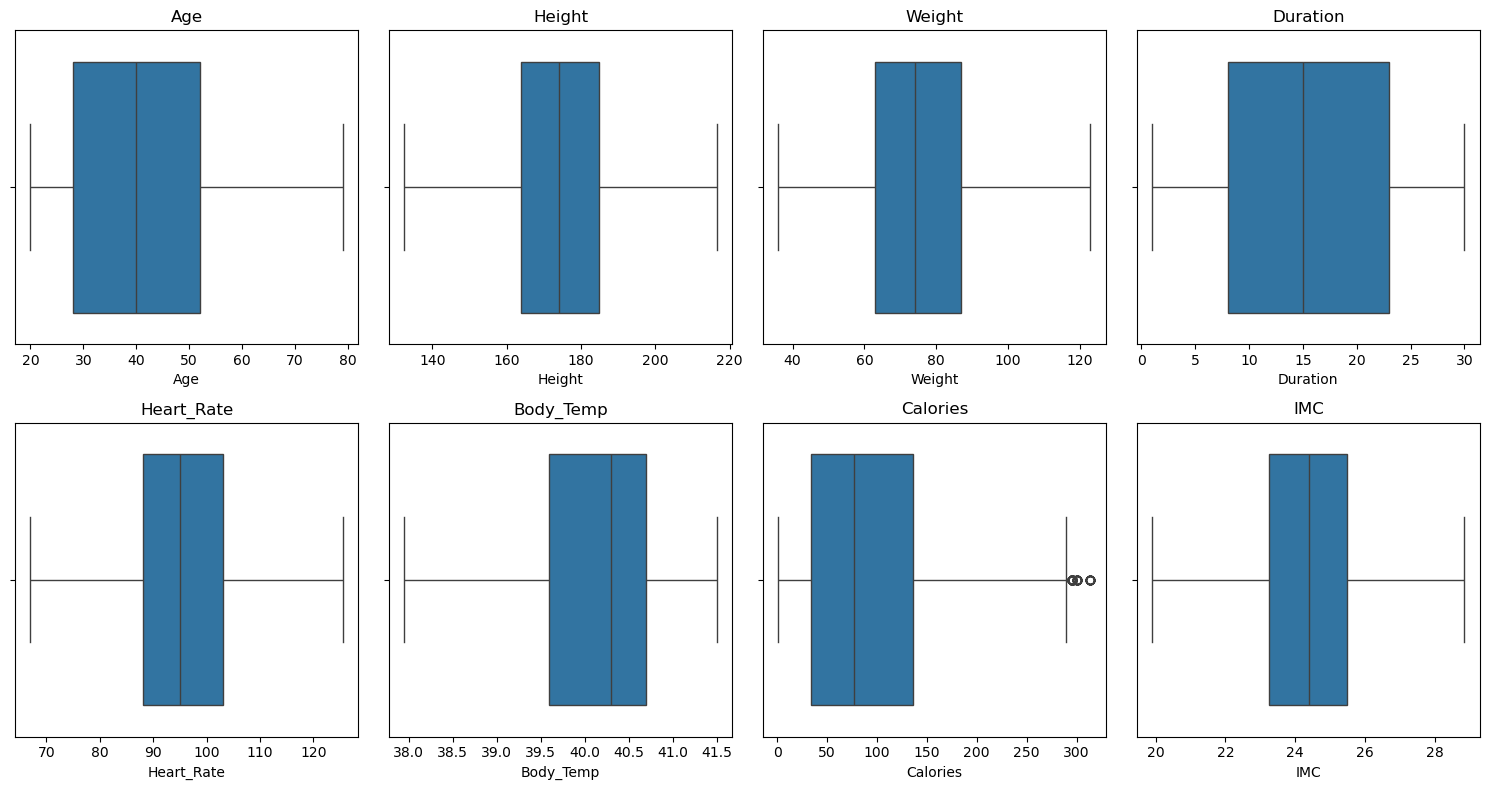

In [17]:
#REVISANDO OUTLIERS NUEVAMENTE
numerical_cols = df_train.select_dtypes(include=["float64", "int64"]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ["id"]]  # target queda fuera

import matplotlib.pyplot as plt
import seaborn as sns

# Ajustar tamaño general
plt.figure(figsize=(15, 8))

# Un boxplot por cada columna numérica
for i, col in enumerate(numerical_cols):
    plt.subplot(2, (len(numerical_cols) + 1) // 2, i + 1)
    sns.boxplot(x=df_train[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

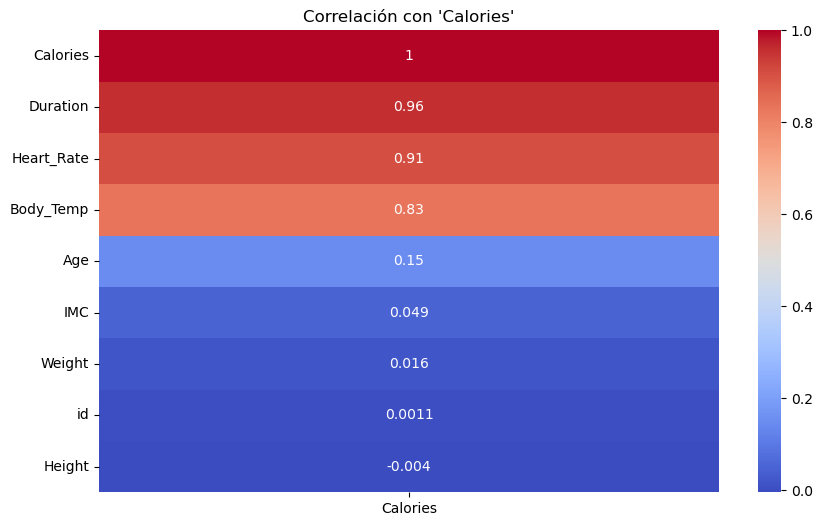

In [18]:
correlation = df_train.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation[['Calories']].sort_values(by='Calories', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlación con 'Calories'")
plt.show()

In [19]:
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})


In [20]:
!pip install catboost

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor

# 1. Separar X e y
X = df_train.drop(columns=['Calories', 'id', 'Height', 'Weight'])
y = df_train['Calories']

# 2. Separar datos para validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Definir los modelos
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Lasso Regression (scaled)": Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=0.1))
    ]),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "CatBoost Regressor": CatBoostRegressor(verbose=0, random_state=42)
}

# 4. Evaluar modelos
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"\n📊 {name}")
    print(f"🔹 RMSE: {rmse:.2f}")
    print(f"🔹 MAE: {mae:.2f}")
    print(f"🔹 R²: {r2:.4f}")


C:\Users\S94\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Linear Regression
🔹 RMSE: 11.12
🔹 MAE: 8.10
🔹 R²: 0.9681


C:\Users\S94\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Random Forest
🔹 RMSE: 4.46
🔹 MAE: 2.81
🔹 R²: 0.9949


C:\Users\S94\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Lasso Regression (scaled)
🔹 RMSE: 11.13
🔹 MAE: 8.08
🔹 R²: 0.9681


C:\Users\S94\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Gradient Boosting
🔹 RMSE: 5.10
🔹 MAE: 3.44
🔹 R²: 0.9933

📊 CatBoost Regressor
🔹 RMSE: 3.97
🔹 MAE: 2.47
🔹 R²: 0.9959


C:\Users\S94\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

# 1. Separar X e y
X = df_train.drop(columns=['Calories', 'id', 'Height', 'Weight'])
y = df_train['Calories']

# 2. Dividir en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Definir modelos base
base_models = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(random_state=42)),
    ('lasso', Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(alpha=0.1))
    ])),
    ('gbr', GradientBoostingRegressor(random_state=42)),
    ('catboost', CatBoostRegressor(verbose=0, random_state=42))
]

# 4. Crear el StackingRegressor
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    passthrough=True
)

# 5. Entrenar el modelo
stacking_model.fit(X_train, y_train)

# 6. Evaluar
y_pred = stacking_model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("\n📊 Stacking Regressor")
print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 MAE: {mae:.2f}")
print(f"🔹 R²: {r2:.4f}")



📊 Stacking Regressor
🔹 RMSE: 3.97
🔹 MAE: 2.46
🔹 R²: 0.9959


C:\Users\S94\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
# Entrenar el modelo con todos los datos disponibles
stacking_model.fit(X, y)

# Preparar datos de test
X_test = df_test.drop(columns=['id', 'Height', 'Weight'])  # Debe coincidir con X

# Hacer predicciones y asegurarse de que no sean negativas
predictions = stacking_model.predict(X_test)
predictions = np.maximum(predictions, 0)


# Crear archivo de submission
submission = pd.DataFrame({
    'id': df_test['id'],
    'Calories': predictions
})

submission.to_csv('submission.csv', index=False)
print("✅ Archivo 'submission.csv' generado correctamente usando Stacking Regressor.")



✅ Archivo 'submission.csv' generado correctamente usando Stacking Regressor.
